In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.tseries.offsets import MonthEnd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [4]:
CWD = Path('.').resolve()
DATA_DIR = CWD / 'data'
print(DATA_DIR)
fndata_path = DATA_DIR / '고금계과제1_v3.3_201301-202408.csv'

C:\Users\chlje\VSCodeProjects\KAIST_MFE\BAF634고금계\hw1\data


In [5]:
from fndata import FnStockData
from fndata import FnMarketData

In [6]:
fn = FnStockData(fndata_path)
#fn은 주식 데이터임
fn.get_items()

array(['종가(원)', '수정계수', '수정주가(원)', '수익률 (1개월)(%)', 'FnGuide Sector',
       '거래정지여부', '관리종목여부', '보통주자본금(천원)', '자본잉여금(천원)', '이익잉여금(천원)',
       '자기주식(천원)', '이연법인세부채(천원)', '매출액(천원)', '매출원가(천원)', '이자비용(천원)',
       '영업이익(천원)', '총자산(천원)', '기말발행주식수 (보통)(주)'], dtype=object)

In [7]:
fnmkt_path = DATA_DIR / '고금계과제_시장수익률_201301-202408.csv'
# 데이터 모듈을 생성하며 기본 전처리들을 수행합니다.
fnmkt = FnMarketData(fnmkt_path)
# long format 불러오기
fnmkt.get_data(format='long', multiindex=True)

Item Name               수익률 (1개월)(%)
date       Symbol Name              
2013-01-31 MKF2000           -0.0162
           KRX 300           -0.0202
2013-02-28 MKF2000            0.0389
           KRX 300            0.0507
2013-03-31 MKF2000           -0.0074
...                              ...
2024-07-31 KRX 300           -0.0097
2024-08-31 MKF2000           -0.0358
           KRX 300           -0.0347
2024-09-20 MKF2000           -0.0610
           KRX 300           -0.0640

[282 rows x 1 columns]

In [8]:
#천원 단위가 아닌 것은 수정주가, 종가 2개다. 
op=fn.get_data('영업이익(천원)')
#op[op.isna()]
op.head()

Symbol,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A014940,A053810,A007390,A002410,A037950,A038880,A015020,A001260,A019660,A023460
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,2.062220e+09,-3.486600e+09,3.603174e+10,2.472122e+09,1.610515e+11,6.183979e+10,6.417736e+10,1.679059e+11,1.135179e+12,-2.122107e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,2.062220e+09,-3.486600e+09,3.603174e+10,2.472122e+09,1.610515e+11,6.183979e+10,6.417736e+10,1.679059e+11,1.135179e+12,-2.122107e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,2.062220e+09,-3.486600e+09,3.603174e+10,2.472122e+09,1.610515e+11,6.183979e+10,6.417736e+10,1.679059e+11,1.135179e+12,-2.122107e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,2.062220e+09,-3.486600e+09,3.603174e+10,2.472122e+09,1.610515e+11,6.183979e+10,6.417736e+10,1.679059e+11,1.135179e+12,-2.122107e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,2.062220e+09,-3.486600e+09,3.603174e+10,2.472122e+09,1.610515e+11,6.183979e+10,6.417736e+10,1.679059e+11,1.135179e+12,-2.122107e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 무위험이자율 파일을 만든다.
rf_path = DATA_DIR / '통안채1년물_월평균_201301-202408.csv'
rf_df = pd.read_csv(rf_path)
rf_df.head()

,변환,원자료
0,2013/01,2.72
1,2013/02,2.69
2,2013/03,2.61
3,2013/04,2.58
4,2013/05,2.58


In [10]:
# rf 무위험이자율은 365일 단위이므로, 1개월 단위로 변환해야 한다.
# (1+r/100)의 1/12 승.
rf_df['Rf'] = (1 + (rf_df['원자료']/100)) ** (1/12) - 1
rf_df.head()

,변환,원자료,Rf
0,2013/01,2.72,0.002239
1,2013/02,2.69,0.002214
2,2013/03,2.61,0.002149
3,2013/04,2.58,0.002125
4,2013/05,2.58,0.002125


In [11]:
# rf의 날짜가 object이므로, 접근하기 쉽게 datetime으로 변환한다. 일은 월말로 한다.
rf_df['date'] = pd.to_datetime(rf_df['변환'], format='%Y/%m') + MonthEnd(0)
rf_df['date'].head()

0   2013-01-31
1   2013-02-28
2   2013-03-31
3   2013-04-30
4   2013-05-31
Name: date, dtype: datetime64[ns]

In [12]:
# 필요없는 이전 일자는 없앤다.
rf_df.drop(columns='변환', inplace=True)
rf_df

,원자료,Rf,date
0,2.720,0.002239,2013-01-31
1,2.690,0.002214,2013-02-28
2,2.610,0.002149,2013-03-31
3,2.580,0.002125,2013-04-30
4,2.580,0.002125,2013-05-31
...,...,...,...
135,3.389,0.002781,2024-04-30
136,3.387,0.002780,2024-05-31
137,3.352,0.002751,2024-06-30
138,3.210,0.002636,2024-07-31


#1. 시장가치를 통해 장부가치, B/M구하기

In [13]:
stock_df=fn.get_data()
stock_df.head()

Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)     영업이익(천원)  이연법인세부채(천원)    이익잉여금(천원)  \
date       Symbol                                                          
2013-01-31 A000020   1.0   6030.0    2062220.0          0.0  170147330.0   
           A000040   1.0   8727.0   -3486600.0    7181340.0    1298918.0   
           A000050   1.0   7874.0   36031739.0   90652345.0  612310562.0   
           A000070   1.0  67800.0    2472122.0  110818108.0  871019983.0   
           A000080   1.0  32000.0  161051461.0   23405084.0  422540903.0   

Item Name             이자비용(천원)     자기주식(천원)    자본잉여금(천원)    종가(원)  \
date       Symbol                                                   
2013-01-31 A000020    384335.0          0.0   26919758.0   6030.0   
           A000040    813333.0      -5044.0    3884892.0    495.0   
           A000050  13944625.0          0.0   13991400.0  86500.0   
           A000070  17176000.0   -9982000.0  355855971.0  67800.0   
           A000080  56438096.0 -122693570.0  709299321.0  32000.0   

Item Name                총자산(천원)  
date       Symbol                 
2013-01-31 A000020  3.161655e+08  
           A000040  1.169316e+08  
           A000050  1.296989e+09  
           A000070  2.595068e+09  
           A000080  3.553147e+09

In [14]:
# 2023-12-31까지만 데이터로 삼는다. 
stock_df=stock_df[stock_df.index.get_level_values(0)<='2023-12-31']

In [15]:
stock_df[['자본잉여금(천원)','이익잉여금(천원)','자기주식(천원)','이연법인세부채(천원)']].fillna(0,inplace=True)
stock_df[['자본잉여금(천원)','이익잉여금(천원)','자기주식(천원)','이연법인세부채(천원)']]

Item Name             자본잉여금(천원)    이익잉여금(천원)     자기주식(천원)  이연법인세부채(천원)
date       Symbol                                                     
2013-01-31 A000020   26919758.0  170147330.0          0.0          0.0
           A000040    3884892.0    1298918.0      -5044.0    7181340.0
           A000050   13991400.0  612310562.0          0.0   90652345.0
           A000070  355855971.0  871019983.0   -9982000.0  110818108.0
           A000080  709299321.0  422540903.0 -122693570.0   23405084.0
...                         ...          ...          ...          ...
2023-12-31 A037950   35966040.0   10415010.0    -112236.0     470288.0
           A038880   50142140.0  -10551022.0   -6581333.0    5080725.0
           A001260   21419137.0   79849777.0    -169271.0          0.0
           A019660   88150884.0  -94326688.0          0.0          0.0
           A023460     628064.0   31515968.0   -7852408.0          0.0

[332209 rows x 4 columns]

In [16]:
# NA는 없다. 
stock_df[['자본잉여금(천원)','이익잉여금(천원)','자기주식(천원)','이연법인세부채(천원)']].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 332209 entries, (Timestamp('2013-01-31 00:00:00'), 'A000020') to (Timestamp('2023-12-31 00:00:00'), 'A023460')
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   자본잉여금(천원)    300713 non-null  float64
 1   이익잉여금(천원)    300713 non-null  float64
 2   자기주식(천원)     300713 non-null  float64
 3   이연법인세부채(천원)  300713 non-null  float64
dtypes: float64(4)
memory usage: 11.5+ MB


In [17]:
# 자기자본의 장부가치: t-1년 12월말의 보통주 자본금에 자본잉여금, 이익잉여금, 자기주식, 이연법인세 부채를 더해 측정
stock_df['장부가치 (천원)'] = (stock_df['자본잉여금(천원)'] + stock_df['이익잉여금(천원)'] + stock_df['보통주자본금(천원)']+stock_df['자기주식(천원)']+stock_df['이연법인세부채(천원)'])
#시장가치: 12월 말의 보통주 주가에 발행주식을 곱해 측정한다. 단, 종가는 천원 단위가 아니기에 1000을 나눠준 후 1000단위라고 해준다. 
stock_df['시장가치 (천원)']=(stock_df['종가(원)'] * stock_df['기말발행주식수 (보통)(주)'])/1000
stock_df.head()


Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)     영업이익(천원)  이연법인세부채(천원)    이익잉여금(천원)  \
date       Symbol                                                          
2013-01-31 A000020   1.0   6030.0    2062220.0          0.0  170147330.0   
           A000040   1.0   8727.0   -3486600.0    7181340.0    1298918.0   
           A000050   1.0   7874.0   36031739.0   90652345.0  612310562.0   
           A000070   1.0  67800.0    2472122.0  110818108.0  871019983.0   
           A000080   1.0  32000.0  161051461.0   23405084.0  422540903.0   

Item Name             이자비용(천원)     자기주식(천원)    자본잉여금(천원)    종가(원)  \
date       Symbol                                                   
2013-01-31 A000020    384335.0          0.0   26919758.0   6030.0   
           A000040    813333.0      -5044.0    3884892.0    495.0   
           A000050  13944625.0          0.0   13991400.0  86500.0   
           A000070  17176000.0   -9982000.0  355855971.0  67800.0   
           A000080  56438096.0 -122693570.0  709299321.0  32000.0   

Item Name                총자산(천원)     장부가치 (천원)     시장가치 (천원)  
date       Symbol                                             
2013-01-31 A000020  3.161655e+08  2.249986e+08  1.684268e+08  
           A000040  1.169316e+08  7.203080e+07  5.907398e+07  
           A000050  1.296989e+09  7.294158e+08  2.155838e+08  
           A000070  2.595068e+09  1.368564e+09  5.223988e+08  
           A000080  3.553147e+09  1.395720e+09  2.223287e+09

In [18]:
# 장부가치가 na가 나왔다는 것은 보통주 자본금이 NA라는 것.
stock_df['장부가치 (천원)'].isna().sum()

31496

In [19]:
# 보통주 자본금이 NA인것은 제거한다. 
stock_df=stock_df[stock_df['장부가치 (천원)'].notna()]

In [20]:
stock_df.head()

Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)     영업이익(천원)  이연법인세부채(천원)    이익잉여금(천원)  \
date       Symbol                                                          
2013-01-31 A000020   1.0   6030.0    2062220.0          0.0  170147330.0   
           A000040   1.0   8727.0   -3486600.0    7181340.0    1298918.0   
           A000050   1.0   7874.0   36031739.0   90652345.0  612310562.0   
           A000070   1.0  67800.0    2472122.0  110818108.0  871019983.0   
           A000080   1.0  32000.0  161051461.0   23405084.0  422540903.0   

Item Name             이자비용(천원)     자기주식(천원)    자본잉여금(천원)    종가(원)  \
date       Symbol                                                   
2013-01-31 A000020    384335.0          0.0   26919758.0   6030.0   
           A000040    813333.0      -5044.0    3884892.0    495.0   
           A000050  13944625.0          0.0   13991400.0  86500.0   
           A000070  17176000.0   -9982000.0  355855971.0  67800.0   
           A000080  56438096.0 -122693570.0  709299321.0  32000.0   

Item Name                총자산(천원)     장부가치 (천원)     시장가치 (천원)  
date       Symbol                                             
2013-01-31 A000020  3.161655e+08  2.249986e+08  1.684268e+08  
           A000040  1.169316e+08  7.203080e+07  5.907398e+07  
           A000050  1.296989e+09  7.294158e+08  2.155838e+08  
           A000070  2.595068e+09  1.368564e+09  5.223988e+08  
           A000080  3.553147e+09  1.395720e+09  2.223287e+09

In [21]:
#장부가치 대 시장가치 비율(B/Mi=Bi/(PiXNi))는 자기자본의 장부가치를 시장가치로 나눈다.
stock_df['B/M']=stock_df['장부가치 (천원)']/stock_df['시장가치 (천원)']
stock_df.head()


Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)  ...  이연법인세부채(천원)    이익잉여금(천원)    이자비용(천원)  \
date       Symbol                  ...                                         
2013-01-31 A000020   1.0   6030.0  ...          0.0  170147330.0    384335.0   
           A000040   1.0   8727.0  ...    7181340.0    1298918.0    813333.0   
           A000050   1.0   7874.0  ...   90652345.0  612310562.0  13944625.0   
           A000070   1.0  67800.0  ...  110818108.0  871019983.0  17176000.0   
           A000080   1.0  32000.0  ...   23405084.0  422540903.0  56438096.0   

Item Name              자기주식(천원)    자본잉여금(천원)    종가(원)       총자산(천원)  \
date       Symbol                                                     
2013-01-31 A000020          0.0   26919758.0   6030.0  3.161655e+08   
           A000040      -5044.0    3884892.0    495.0  1.169316e+08   
           A000050          0.0   13991400.0  86500.0  1.296989e+09   
           A000070   -9982000.0  355855971.0  67800.0  2.595068e+09   
           A000080 -122693570.0  709299321.0  32000.0  3.553147e+09   

Item Name              장부가치 (천원)     시장가치 (천원)       B/M  
date       Symbol                                         
2013-01-31 A000020  2.249986e+08  1.684268e+08  1.335884  
           A000040  7.203080e+07  5.907398e+07  1.219332  
           A000050  7.294158e+08  2.155838e+08  3.383445  
           A000070  1.368564e+09  5.223988e+08  2.619769  
           A000080  1.395720e+09  2.223287e+09  0.627773  

[5 rows x 21 columns]

In [22]:
'''['종가(원)', '수정계수', '수정주가(원)', '수익률 (1개월)(%)', 'FnGuide Sector',
       '거래정지여부', '관리종목여부', '보통주자본금(천원)', '자본잉여금(천원)', '이익잉여금(천원)',
       '자기주식(천원)', '이연법인세부채(천원)', '매출액(천원)', '매출원가(천원)', '이자비용(천원)',
       '영업이익(천원)', '총자산(천원)', '기말발행주식수 (보통)(주)'], dtype=object)'''

"['종가(원)', '수정계수', '수정주가(원)', '수익률 (1개월)(%)', 'FnGuide Sector',\n       '거래정지여부', '관리종목여부', '보통주자본금(천원)', '자본잉여금(천원)', '이익잉여금(천원)',\n       '자기주식(천원)', '이연법인세부채(천원)', '매출액(천원)', '매출원가(천원)', '이자비용(천원)',\n       '영업이익(천원)', '총자산(천원)', '기말발행주식수 (보통)(주)'], dtype=object)"

In [23]:
#일단 B/M 중에서 무한대의 값은 없다. 
# B/M 중에서 np.nan 인것들은 없앤다. 
#stock_df.dropna(subset='B/M', inplace=True)
# B/M의 NaN값 제거 이후 열 별 NaN 개수
stock_df['B/M'].isna().sum()

51317

In [24]:
stock_df['시장가치 (천원)']

date        Symbol 
2013-01-31  A000020    1.684268e+08
            A000040    5.907398e+07
            A000050    2.155838e+08
            A000070    5.223988e+08
            A000080    2.223287e+09
                           ...     
2023-12-31  A037950    1.097818e+08
            A038880    1.329409e+08
            A001260    7.531749e+07
            A019660    3.482554e+07
            A023460    7.138680e+07
Name: 시장가치 (천원), Length: 300713, dtype: float64

In [25]:
# 일단 (일자/주식번호)의 멀티인덱스
# 날짜마다 있는 주식들의 중앙값을, 일자별로 groupby를 해서 얻는다
stock_df['size_quantiles'] = stock_df.groupby('date')['시장가치 (천원)'].transform(lambda x: pd.qcut(x, 2, labels=['Small', 'Big']))
stock_df['size_quantiles']

date        Symbol 
2013-01-31  A000020      Big
            A000040    Small
            A000050      Big
            A000070      Big
            A000080      Big
                       ...  
2023-12-31  A037950    Small
            A038880      Big
            A001260    Small
            A019660    Small
            A023460    Small
Name: size_quantiles, Length: 300713, dtype: category
Categories (2, object): ['Small' < 'Big']

In [26]:
# B/M이 na인 것 삭제
stock_df=stock_df[stock_df['B/M'].notna()]
stock_df.head()

Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)  ...    이익잉여금(천원)    이자비용(천원)     자기주식(천원)  \
date       Symbol                  ...                                         
2013-01-31 A000020   1.0   6030.0  ...  170147330.0    384335.0          0.0   
           A000040   1.0   8727.0  ...    1298918.0    813333.0      -5044.0   
           A000050   1.0   7874.0  ...  612310562.0  13944625.0          0.0   
           A000070   1.0  67800.0  ...  871019983.0  17176000.0   -9982000.0   
           A000080   1.0  32000.0  ...  422540903.0  56438096.0 -122693570.0   

Item Name             자본잉여금(천원)    종가(원)       총자산(천원)     장부가치 (천원)  \
date       Symbol                                                      
2013-01-31 A000020   26919758.0   6030.0  3.161655e+08  2.249986e+08   
           A000040    3884892.0    495.0  1.169316e+08  7.203080e+07   
           A000050   13991400.0  86500.0  1.296989e+09  7.294158e+08   
           A000070  355855971.0  67800.0  2.595068e+09  1.368564e+09   
           A000080  709299321.0  32000.0  3.553147e+09  1.395720e+09   

Item Name              시장가치 (천원)       B/M  size_quantiles  
date       Symbol                                           
2013-01-31 A000020  1.684268e+08  1.335884             Big  
           A000040  5.907398e+07  1.219332           Small  
           A000050  2.155838e+08  3.383445             Big  
           A000070  5.223988e+08  2.619769             Big  
           A000080  2.223287e+09  0.627773             Big  

[5 rows x 22 columns]

In [27]:
def qcut_BM(x):
    try:
        return pd.qcut(x, 3, labels=['Low', 'Mid', 'High'])
    except ValueError:  # 구간을 나눌 수 없는 경우
        return pd.Series(np.nan, index=x.index)
stock_df['bm_quantiles'] = stock_df.groupby('date')['B/M'].transform(qcut_BM)
stock_df['bm_quantiles']

date        Symbol 
2013-01-31  A000020     Mid
            A000040     Mid
            A000050    High
            A000070    High
            A000080     Low
                       ... 
2023-12-31  A037950     Mid
            A038880     Low
            A001260    High
            A019660     Low
            A023460    High
Name: bm_quantiles, Length: 249396, dtype: category
Categories (3, object): ['Low' < 'Mid' < 'High']

In [28]:
df_smb = stock_df.groupby(['date', 'size_quantiles', 'bm_quantiles'])['수익률 (1개월)(%)'].mean().unstack(['size_quantiles', 'bm_quantiles'])
small_avg = df_smb[('Small', 'Low')] + df_smb[('Small', 'Mid')] + df_smb[('Small', 'High')]
big_avg = df_smb[('Big', 'Low')] + df_smb[('Big', 'Mid')] + df_smb[('Big', 'High')]

smb = (small_avg / 3) - (big_avg / 3)
smb

date
2013-01-31    2.600442
2013-02-28   -1.950661
2013-03-31   -1.658379
2013-04-30   -1.376561
2013-05-31    2.725522
                ...   
2023-08-31   -0.983170
2023-09-30   -2.916533
2023-10-31   -1.504933
2023-11-30   -2.952560
2023-12-31   -4.266924
Length: 132, dtype: float64

In [29]:
df_hml = stock_df.groupby(['date', 'size_quantiles', 'bm_quantiles'])['수익률 (1개월)(%)'].mean().unstack(['size_quantiles', 'bm_quantiles'])

high_hml = df_hml[('Small', 'High')] + df_hml[('Big', 'High')]
low_hml = df_hml[('Small', 'Low')] + df_hml[('Big', 'Low')]

hml = (high_hml - low_hml) / 2
hml

date
2013-01-31   -4.522588
2013-02-28   -3.202426
2013-03-31    0.107812
2013-04-30   -3.135930
2013-05-31   -0.567312
                ...   
2023-08-31   -3.482081
2023-09-30   -1.102249
2023-10-31    5.279382
2023-11-30   -3.894306
2023-12-31   -6.129002
Length: 132, dtype: float64

In [30]:
# RMW를 위해 영업이익을 확인해야 하는데, 이 값이 na이면 0처리한다. 
stock_df['영업이익(천원)'].isna().sum()

0

In [31]:
# RMW를 위한 수익성 지수 측정. 
stock_df['OP'] = stock_df['영업이익(천원)'] / stock_df['장부가치 (천원)']
stock_df['OP'].isna().sum()

0

In [32]:
def qcut_OP(x):
    try:
        return pd.qcut(x, [0, 0.3, 0.7, 1.0], labels=['Weak', 'Neutral', 'Robust'])
    except ValueError:  # 구간을 나눌 수 없는 경우
        return pd.Series(np.nan, index=x.index)
stock_df['OP_quantiles'] = stock_df.groupby('date')['OP'].transform(qcut_OP)
stock_df['OP_quantiles']

date        Symbol 
2013-01-31  A000020       Weak
            A000040       Weak
            A000050    Neutral
            A000070       Weak
            A000080    Neutral
                        ...   
2023-12-31  A037950    Neutral
            A038880       Weak
            A001260    Neutral
            A019660       Weak
            A023460       Weak
Name: OP_quantiles, Length: 249396, dtype: category
Categories (3, object): ['Weak' < 'Neutral' < 'Robust']

In [33]:
df_rmv = stock_df.groupby(['date', 'size_quantiles', 'OP_quantiles'])['수익률 (1개월)(%)'].mean().unstack(['size_quantiles', 'OP_quantiles'])

high_rmw = df_rmv[('Small', 'Robust')] + df_rmv[('Big', 'Robust')]
low_rmw = df_rmv[('Small', 'Weak')] + df_rmv[('Big', 'Weak')]

rmw = (high_rmw - low_rmw) / 2
rmw

date
2013-01-31   -2.244038
2013-02-28    4.084325
2013-03-31    5.087957
2013-04-30    5.882182
2013-05-31    0.671398
                ...   
2023-08-31   -0.442551
2023-09-30    1.701914
2023-10-31    5.900704
2023-11-30   -2.752327
2023-12-31   -4.830843
Length: 132, dtype: float64

In [34]:
#시장 데이터 전처리
df_mkt=fnmkt.get_data(format='wide')
df_mkt=df_mkt[df_mkt.index.get_level_values(0)<='2023-12-31']
df_mkt=df_mkt['MKF2000']
df_mkt

date
2013-01-31   -0.0162
2013-02-28    0.0389
2013-03-31   -0.0074
2013-04-30   -0.0219
2013-05-31    0.0233
               ...  
2023-08-31   -0.0253
2023-09-30   -0.0232
2023-10-31   -0.0775
2023-11-30    0.0948
2023-12-31    0.0578
Name: MKF2000, Length: 132, dtype: float64

In [35]:
rf_df=rf_df[rf_df['date']<='2023-12-31']
rf_df

,원자료,Rf,date
0,2.720,0.002239,2013-01-31
1,2.690,0.002214,2013-02-28
2,2.610,0.002149,2013-03-31
3,2.580,0.002125,2013-04-30
4,2.580,0.002125,2013-05-31
...,...,...,...
127,3.594,0.002947,2023-08-31
128,3.651,0.002993,2023-09-30
129,3.745,0.003069,2023-10-31
130,3.687,0.003022,2023-11-30


In [36]:
mr=pd.merge(rf_df, df_mkt,on='date')
mr


,원자료,Rf,date,MKF2000
0,2.720,0.002239,2013-01-31,-0.0162
1,2.690,0.002214,2013-02-28,0.0389
2,2.610,0.002149,2013-03-31,-0.0074
3,2.580,0.002125,2013-04-30,-0.0219
4,2.580,0.002125,2013-05-31,0.0233
...,...,...,...,...
127,3.594,0.002947,2023-08-31,-0.0253
128,3.651,0.002993,2023-09-30,-0.0232
129,3.745,0.003069,2023-10-31,-0.0775
130,3.687,0.003022,2023-11-30,0.0948


In [37]:
mr['excess']=mr['MKF2000']-mr['Rf']
mr['excess']


0     -0.018439
1      0.036686
2     -0.009549
3     -0.024025
4      0.021175
         ...   
127   -0.028247
128   -0.026193
129   -0.080569
130    0.091778
131    0.054930
Name: excess, Length: 132, dtype: float64

In [38]:
#지금까지 excess, smb, hml, rmw 제작. 
stock_df['invest'] = stock_df.groupby('date')['총자산(천원)'].transform(lambda x: (x - x.shift(12)) / x.shift(12))

In [39]:
# 이것만 특별히 3:4:3 구간 간격.
def qcut_invest(x):
    try:
        return pd.qcut(x, [0, 0.3, 0.7, 1.0], labels=['Conservative', 'Neutral', 'Aggressive'])
    except ValueError:  # 구간을 나눌 수 없는 경우
        return pd.Series(np.nan, index=x.index)
stock_df['invest_quantiles'] = stock_df.groupby('date')['invest'].transform(qcut_invest)

In [40]:
cma_data = stock_df.groupby(['date', 'size_quantiles', 'invest_quantiles'])['수익률 (1개월)(%)'].mean().unstack(['size_quantiles', 'invest_quantiles'])

high_invest = cma_data[('Small', 'Aggressive')] + cma_data[('Big', 'Aggressive')]
low_invest = cma_data[('Small', 'Conservative')] + cma_data[('Big', 'Conservative')]

cma = low_invest - high_invest
cma

date
2013-01-31    5.609555
2013-02-28   -0.455394
2013-03-31    1.934212
2013-04-30    2.695254
2013-05-31    0.497148
                ...   
2023-08-31    6.378186
2023-09-30    1.354000
2023-10-31   -2.635470
2023-11-30    0.665910
2023-12-31    7.473959
Length: 132, dtype: float64

In [41]:
# 5팩터 최종
d={'Mkt_RF':mr['excess'].values,'SMB': smb.values,'HML': hml.values,'RMW': rmw.values,'CMA': cma.values}
F_5 = pd.DataFrame(data=d, index=smb.index)
F_5
#_5factors.dropna(how='all', inplace=True)
#_5factors

,Mkt_RF,SMB,HML,RMW,CMA
date,,,,,
2013-01-31,-0.018439,2.600442,-4.522588,-2.244038,5.609555
2013-02-28,0.036686,-1.950661,-3.202426,4.084325,-0.455394
2013-03-31,-0.009549,-1.658379,0.107812,5.087957,1.934212
2013-04-30,-0.024025,-1.376561,-3.135930,5.882182,2.695254
2013-05-31,0.021175,2.725522,-0.567312,0.671398,0.497148
...,...,...,...,...,...
2023-08-31,-0.028247,-0.983170,-3.482081,-0.442551,6.378186
2023-09-30,-0.026193,-2.916533,-1.102249,1.701914,1.354000
2023-10-31,-0.080569,-1.504933,5.279382,5.900704,-2.635470


In [42]:
F_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt_RF  132 non-null    float64
 1   SMB     132 non-null    float64
 2   HML     132 non-null    float64
 3   RMW     132 non-null    float64
 4   CMA     132 non-null    float64
dtypes: float64(5)
memory usage: 6.2 KB


In [43]:
stock_df['size_quantiles_by5'] = pd.qcut(stock_df['시장가치 (천원)'], 5, labels=['Small', '2', '3', '4', 'Big'])
stock_df['size_quantiles_by5']

date        Symbol 
2013-01-31  A000020        4
            A000040        2
            A000050        4
            A000070      Big
            A000080      Big
                       ...  
2023-12-31  A037950        3
            A038880        3
            A001260        2
            A019660    Small
            A023460        2
Name: size_quantiles_by5, Length: 249396, dtype: category
Categories (5, object): ['Small' < '2' < '3' < '4' < 'Big']

In [44]:
def qcut_BM_by5(x):
    try:
        return pd.qcut(x, 5, labels=['Low', '2', '3', '4', 'High'])
    except ValueError:  # 구간을 나눌 수 없는 경우
        return pd.Series(np.nan, index=x.index)
stock_df['bm_quantiles_by5'] = stock_df.groupby('date')['B/M'].transform(qcut_BM_by5)
stock_df['bm_quantiles_by5']

date        Symbol 
2013-01-31  A000020       4
            A000040       4
            A000050    High
            A000070    High
            A000080       2
                       ... 
2023-12-31  A037950       3
            A038880       2
            A001260    High
            A019660     Low
            A023460       4
Name: bm_quantiles_by5, Length: 249396, dtype: category
Categories (5, object): ['Low' < '2' < '3' < '4' < 'High']

In [45]:
stock_df['수익률 (1개월)(%)']

date        Symbol 
2013-01-31  A000020   -0.17
            A000040    0.20
            A000050   -3.46
            A000070   -4.51
            A000080    5.26
                       ... 
2023-12-31  A037950   -3.77
            A038880    5.87
            A001260   -4.13
            A019660   -8.50
            A023460    5.73
Name: 수익률 (1개월)(%), Length: 249396, dtype: float64

In [46]:
s=pd.Series(rf_df['Rf'].values,index=smb.index)
s

date
2013-01-31    0.002239
2013-02-28    0.002214
2013-03-31    0.002149
2013-04-30    0.002125
2013-05-31    0.002125
                ...   
2023-08-31    0.002947
2023-09-30    0.002993
2023-10-31    0.003069
2023-11-30    0.003022
2023-12-31    0.002870
Length: 132, dtype: float64

In [47]:
stock_df['excess_value'] = stock_df['수익률 (1개월)(%)'] - stock_df.index.get_level_values('date').map(s)

In [48]:
stock_df.head()

Item Name          FnGuide Sector 거래정지여부 관리종목여부  기말발행주식수 (보통)(주)  \
date       Symbol                                                  
2013-01-31 A000020             의료     정상     정상       27931470.0   
           A000040          경기소비재     정상     정상      119341379.0   
           A000050          경기소비재     정상     정상        2492298.0   
           A000070            산업재     정상     정상        7704997.0   
           A000080          필수소비재     정상     정상       69477714.0   

Item Name                매출액(천원)      매출원가(천원)   보통주자본금(천원)  수익률 (1개월)(%)  \
date       Symbol                                                           
2013-01-31 A000020  2.202406e+08  1.165344e+08   27931470.0         -0.17   
           A000040  9.955327e+07  9.199679e+07   59670690.0          0.20   
           A000050  3.471896e+08  2.514682e+08   12461490.0         -3.46   
           A000070  2.329145e+09  2.025952e+09   40852325.0         -4.51   
           A000080  1.897469e+09  1.074666e+09  363168055.0          5.26   

Item Name           수정계수  수정주가(원)  ...       B/M  size_quantiles  \
date       Symbol                  ...                             
2013-01-31 A000020   1.0   6030.0  ...  1.335884             Big   
           A000040   1.0   8727.0  ...  1.219332           Small   
           A000050   1.0   7874.0  ...  3.383445             Big   
           A000070   1.0  67800.0  ...  2.619769             Big   
           A000080   1.0  32000.0  ...  0.627773             Big   

Item Name           bm_quantiles        OP  OP_quantiles  invest  \
date       Symbol                                                  
2013-01-31 A000020           Mid  0.009165          Weak     NaN   
           A000040           Mid -0.048404          Weak     NaN   
           A000050          High  0.049398       Neutral     NaN   
           A000070          High  0.001806          Weak     NaN   
           A000080           Low  0.115390       Neutral     NaN   

Item Name           invest_quantiles  size_quantiles_by5  bm_quantiles_by5  \
date       Symbol                                                            
2013-01-31 A000020               NaN                   4                 4   
           A000040               NaN                   2                 4   
           A000050               NaN                   4              High   
           A000070               NaN                 Big              High   
           A000080               NaN                 Big                 2   

Item Name           excess_value  
date       Symbol                 
2013-01-31 A000020     -0.172239  
           A000040      0.197761  
           A000050     -3.462239  
           A000070     -4.512239  
           A000080      5.257761  

[5 rows x 30 columns]

In [49]:
portfolios = stock_df.groupby(['date', 'size_quantiles_by5', 'bm_quantiles_by5']).apply(
    lambda group: group['excess_value'].mean(skipna=True)
    ).unstack(level=['size_quantiles_by5', 'bm_quantiles_by5'])

In [50]:
portfolios

size_quantiles_by5      Small                                           \
bm_quantiles_by5          Low          2         3         4      High   
date                                                                     
2013-01-31           9.636761   7.771761  4.349245  2.604715  3.645882   
2013-02-28           5.689407   4.610350  3.641422  2.587049  1.860891   
2013-03-31           5.672257   1.043383  3.322592  3.491641  2.800578   
2013-04-30           3.121668   4.428220  2.793548  1.160240 -0.010796   
2013-05-31           7.298045   4.495592  4.929289  4.718751  5.370713   
...                       ...        ...       ...       ...       ...   
2023-08-31          -1.117947   3.447053 -2.037144 -0.293716 -1.591934   
2023-09-30          -9.100771  -3.423538 -5.789774 -5.263178 -5.969816   
2023-10-31         -11.653296 -10.240233 -8.101772 -8.324235 -8.070669   
2023-11-30           0.212566   5.430508  4.917391  6.195247  2.837323   
2023-12-31          -1.539166  -2.311779 -0.154299 -0.892420 -0.780581   

size_quantiles_by5          2                                           ...  \
bm_quantiles_by5          Low          2         3         4      High  ...   
date                                                                    ...   
2013-01-31           9.321928   3.997444  4.021397  2.807761  2.106778  ...   
2013-02-28           1.524452   7.075850  6.768695  4.427441  2.393668  ...   
2013-03-31           4.965158   3.143221  6.605851  5.696471  5.234141  ...   
2013-04-30           5.247475   8.434542  6.307726  4.109805 -0.669817  ...   
2013-05-31           6.353208   5.086446  5.837208  5.075875  2.170708  ...   
...                       ...        ...       ...       ...       ...  ...   
2023-08-31           5.718207   2.653877  2.300024  1.254813  0.219264  ...   
2023-09-30           0.110207  -5.362300 -5.231593 -4.908426 -4.320333  ...   
2023-10-31         -13.154631 -13.067978 -8.210665 -7.049735 -5.951557  ...   
2023-11-30           5.520538   4.776690  6.455778  5.943543  3.651585  ...   
2023-12-31           4.348963   0.784130  1.730248  1.666896 -0.218391  ...   

size_quantiles_by5          4                                          \
bm_quantiles_by5          Low         2         3         4      High   
date                                                                    
2013-01-31           3.267458  4.085212  2.941864  0.331223  0.571445   
2013-02-28           8.097496  8.062314  5.161470  4.530911  1.091500   
2013-03-31           6.363317  4.568851  5.535565  6.674184  6.703797   
2013-04-30           4.986270  9.926313  5.230625  6.237552  6.852875   
2013-05-31           3.424665  1.763330  2.298986  0.667875  2.618764   
...                       ...       ...       ...       ...       ...   
2023-08-31           8.826785  2.660523  0.976401  2.700788 -1.375937   
2023-09-30           0.855341 -0.328333 -2.509356 -4.083804 -2.763666   
2023-10-31         -13.979640 -9.557735 -6.845688 -6.504069 -4.434944   
2023-11-30          11.104602  8.515189  6.825220  4.120445  4.980520   
2023-12-31          18.392718  6.675255  4.506797  2.070335  0.139521   

size_quantiles_by5        Big                                           
bm_quantiles_by5          Low          2         3         4      High  
date                                                                    
2013-01-31           4.860660  -0.741926 -0.030508 -0.815439 -0.143489  
2013-02-28           6.706299   4.887452  3.008277  4.356186  3.947161  
2013-03-31           4.039824   3.370637  2.207851  2.131851  1.702061  
2013-04-30           2.002875   5.950857  3.009805 -1.231584 -1.218925  
2013-05-31           1.579191   2.553392  0.102790  0.612747  2.543292  
...                       ...        ...       ...       ...       ...  
2023-08-31           6.754598  -0.030131  1.297917  1.132438  0.097281  
2023-09-30          -1.576623  -1.693667 -0.907330  0.606007  0.955243  
2023-10-31         -11.664735 

In [51]:
portfolios.columns

MultiIndex([('Small',  'Low'),
            ('Small',    '2'),
            ('Small',    '3'),
            ('Small',    '4'),
            ('Small', 'High'),
            (    '2',  'Low'),
            (    '2',    '2'),
            (    '2',    '3'),
            (    '2',    '4'),
            (    '2', 'High'),
            (    '3',  'Low'),
            (    '3',    '2'),
            (    '3',    '3'),
            (    '3',    '4'),
            (    '3', 'High'),
            (    '4',  'Low'),
            (    '4',    '2'),
            (    '4',    '3'),
            (    '4',    '4'),
            (    '4', 'High'),
            (  'Big',  'Low'),
            (  'Big',    '2'),
            (  'Big',    '3'),
            (  'Big',    '4'),
            (  'Big', 'High')],
           names=['size_quantiles_by5', 'bm_quantiles_by5'])

In [52]:
meanss=[portfolios[midx].mean() for midx in portfolios.columns]
final25=pd.DataFrame({'Small':meanss[0:5],'2':meanss[5:10],'3':meanss[10:15],'4':meanss[15:20],'Big':meanss[20:]})
final_25=final25.T
final_25.columns=['Low','2','3','4','High']
final_25

,Low,2,3,4,High
Small,1.129403,0.015732,-0.129592,-0.438410,-1.022357
2,2.903918,1.561923,0.921288,0.078330,-0.297692
3,4.215443,1.896328,1.285025,0.639782,-0.051949
4,4.899440,2.670900,1.544126,0.753432,0.126086
Big,4.342127,1.767693,1.089502,0.645112,-0.241520


In [53]:
final_25.loc['Small-Big']=final_25.loc['Small']-final_25.loc['Big']
final_25

,Low,2,3,4,High
Small,1.129403,0.015732,-0.129592,-0.438410,-1.022357
2,2.903918,1.561923,0.921288,0.078330,-0.297692
3,4.215443,1.896328,1.285025,0.639782,-0.051949
4,4.899440,2.670900,1.544126,0.753432,0.126086
Big,4.342127,1.767693,1.089502,0.645112,-0.241520
Small-Big,-3.212724,-1.751961,-1.219095,-1.083521,-0.780838


In [54]:
final_25['High-Low']=final_25['High']-final_25['Low']
final_25.loc['Small-Big','High-Low']='.'
final_25

,Low,2,3,4,High,High-Low
Small,1.129403,0.015732,-0.129592,-0.438410,-1.022357,-2.15176
2,2.903918,1.561923,0.921288,0.078330,-0.297692,-3.20161
3,4.215443,1.896328,1.285025,0.639782,-0.051949,-4.267391
4,4.899440,2.670900,1.544126,0.753432,0.126086,-4.773354
Big,4.342127,1.767693,1.089502,0.645112,-0.241520,-4.583647
Small-Big,-3.212724,-1.751961,-1.219095,-1.083521,-0.780838,.


(재필)

욱이 데이터 플롯

<Axes: xlabel='date'>

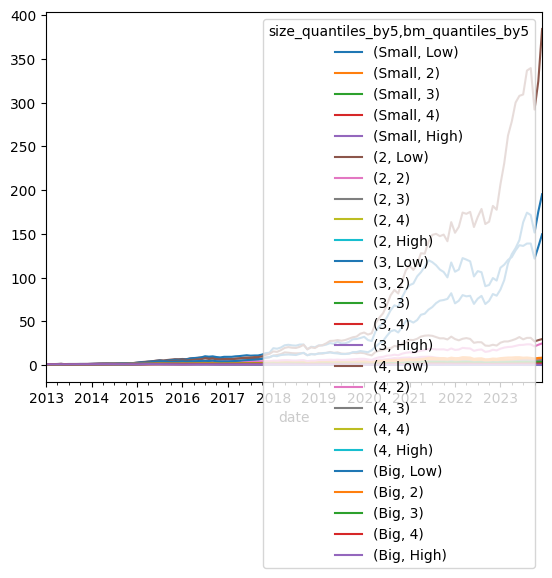

In [56]:
(portfolios/100 + 1).cumprod().plot()